imports

In [2]:
import torch
from torch.optim import Optimizer
import torch.nn as nn
from backpack import backpack, extend
from backpack.extensions import HMP, DiagHessian
from backpack.utils.examples import get_mnist_dataloder
import matplotlib.pyplot as plt

import time
import numpy as np

NUM_EPOCHS = 1

PRINT_EVERY = 50
MAX_ITER = 200
BATCH_SIZE = 64
DEVICE = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
torch.manual_seed(0)

util functions as needed

In [3]:
def accuracy(output, targets):
    predictions = output.argmax(dim=1, keepdim=True).view_as(targets)
    return predictions.eq(targets).float().mean().item()

#### model definition + data loading

In [4]:
# def CNN(outputs=10, channels=(16, 32), fc_dim=32, kernels=(2, 4)):
#     return nn.Sequential(
#         nn.Conv2d(1, channels[0], kernels[0], stride=2, padding=0),
#         nn.ReLU(),
#         nn.Conv2d(channels[0], channels[1], kernels[1], stride=2, padding=0),
#         nn.ReLU(),
#         nn.MaxPool2d(2, stride=1),
#         nn.Flatten(),
#         nn.Linear(channels[1] * 4 * 4, fc_dim),
#         nn.ReLU(),
#         nn.Linear(fc_dim, outputs),
#     )

def MLP():
    return nn.Sequential(nn.Flatten(), nn.Linear(784,10, bias=False), nn.Sigmoid())

mnist_dataloader = get_mnist_dataloder(batch_size=BATCH_SIZE)

model = MLP().to(DEVICE)
loss_function = nn.CrossEntropyLoss().to(DEVICE)

add the model to backpack

In [5]:
model = extend(model)
loss_function = extend(loss_function)

#### computing the hessian for a small batch to see an example

In [6]:
x, y = next(iter(mnist_dataloader))
x, y = x.to(DEVICE), y.to(DEVICE)

logits = model(x)
loss = loss_function(logits, y)
with backpack(DiagHessian(), HMP()):
    loss.backward()

The shape of the hessian would be (20, 784, 784), so the diagonal taken for each element would be of shape 784

In [8]:
def rademacher(V, shape):
    return ((torch.rand(V, *shape)<0.5))*2-1

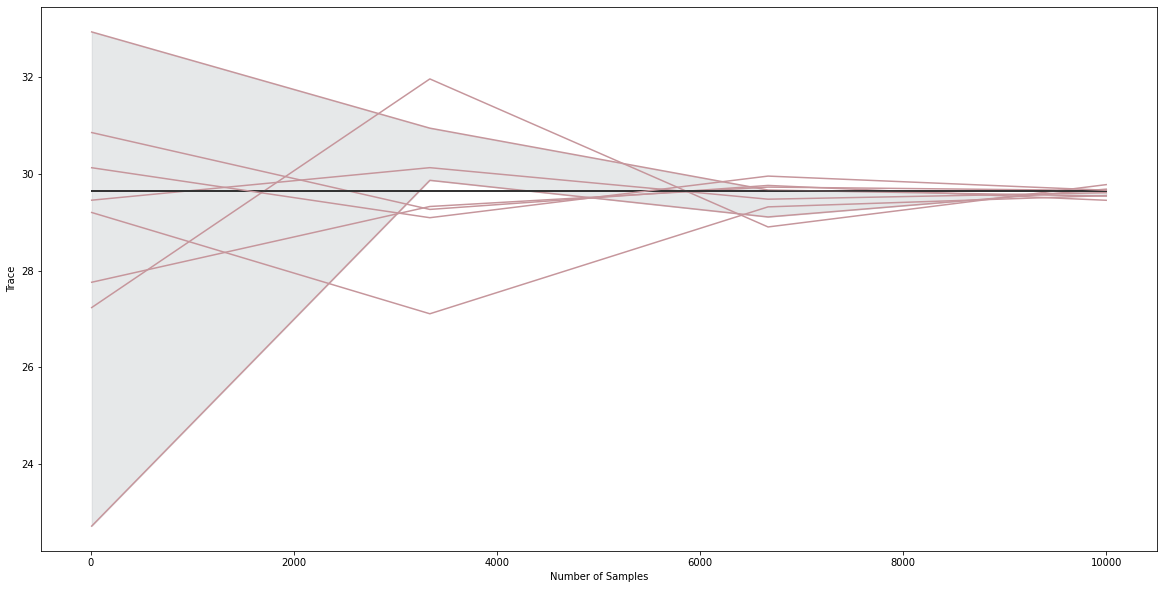

In [11]:
# %%
# PLOTTING
# ----------------------------------------
# Here, we plot the convergence of the trace approximated via the hutchinsons method to the true trace value obtained from the diagonal. 
# Lets get some util functions first and consider the weights of only one layer to plot it, we can choose any of the linear layers to plot.

parameter = "1.weight"
for n, p in model.named_parameters():
    if n == parameter:
        name, param = n, p


dark = np.array([51.0, 51.0, 51.0]) / 255.0
red = np.array([141.0, 45.0, 57.0]) / 255.0
lred = np.array([1, 1, 1]) - 0.5 * (np.array([1, 1, 1]) - red)
gray = np.array([175.0, 179.0, 183.0]) / 255.0

def plotfig(tr, tr_rad, max_tr, min_tr):
    plt.xlabel("Number of Samples")
    plt.ylabel("Trace")
    plt.plot(X, tr, color=dark)
    plt.plot(X, tr_rad, color=lred)

# here, define the number of samples by changing the exponential and samples parameter.

exponential = 4
samples = 10
X = np.linspace(samples, samples**exponential, exponential)
plt.rcParams["figure.figsize"] = (20, 10)
fig, ax = plt.subplots(1, 1)

sample_list = [pow(samples, i+1) for i in range(exponential)]

tr_hutchinson_all = []
for i in range(8):
    torch.manual_seed(i)
    tr = []
    tr_hutchinson = []
    for V in sample_list:
        vec = rademacher(V, param.shape).to(param.dtype)

        trace = (param.diag_h).sum()
        tr.append(trace.detach())

        trace_hutchinson = (torch.einsum('ijk,ijk->i', vec, param.hmp(vec)).sum()) / V
        tr_hutchinson.append(trace_hutchinson.detach())    
    plotfig(tr, tr_hutchinson, max(tr_hutchinson), min(tr_hutchinson))
    tr_hutchinson_all.append(tr_hutchinson)
    
    
plt.fill_between(X, max(tr_hutchinson_all), min(tr_hutchinson_all), color=gray, alpha=0.3)

**Note**: we need to sample the random vector from Rademacher distribution

In [ ]:
# RUNTIME COMPARISON
def trace_computation_hutchinsons(V):
    for v in range(V):
        tr_rad_list = []
        for name, param in model.named_parameters():
            vec = (((torch.rand(V, *param.shape)<0.5))*2-1).to(param.dtype)
            trace_rad = (torch.einsum('ijk,ijk->i', vec, param.hmp(vec)).sum()) # dividing by samples
            tr_rad_list.append(trace_rad.item())
    tr_rad = sum(tr_rad_list) / V
    print(tr_rad)

def trace_computation_backpack(V):
    for name, param in model.named_parameters():
        trace = (param.diag_h).sum()
        print(trace)
        
V = 1000 #10000 test
start = time.time()
trace_computation_hutchinsons(V)
print(time.time() - start)

start_bp = time.time()
trace_computation_backpack(V)
print(time.time() - start_bp)